In [2]:
from datascience import *
import numpy as np
import re
from re import search
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
# scrape_table function from video demo
import pandas as pd
def scrape_table(table):
    df = pd.read_html(str(table))
    df = pd.DataFrame(df[0])
    return Table.from_df(df)

In [4]:
r = requests.get("https://www.numbeo.com/cost-of-living/prices_by_country.jsp?itemId=6&regionCode=019&displayCurrency=CAD")
coke_text = BeautifulSoup(r.text, "html.parser")
coke_text_table = coke_text.find_all("table")[1]
coke_table = scrape_table(coke_text_table).drop("Rank").relabel("Coke/Pepsi (0.33 liter bottle)", "Price in CAD")
coke_table

Country,Price in CAD
Kazakhstan,0.77
Paraguay,1.17
Portugal,1.95
Greece,2.52
Latvia,1.55
Iran,1.15
Morocco,0.63
Panama,2.01
Guatemala,1.38
Iraq,0.58


In [5]:
def convert(cur_from, cur_to, amount):
    payload = {
        'from': cur_from,
        'to': cur_to,
        'amount': amount,
        'api_key': '0a5659758c74b6dd01f96fdbc8fab87d'
    }
    r = requests.get('https://api.currencyscoop.com/v1/convert', params = payload)
    currency = r.json()
    return currency['response']['value']

In [6]:
#stolen shamlessly from example code
currency_url = "https://currencyscoop.com/supported-currencies"
currency_request = requests.get(currency_url)
currency_soup = BeautifulSoup(currency_request.text, 'html.parser')
currency_table = currency_soup.find("table")
currency_codes = scrape_table(currency_table)

codes = make_array()
for each_country in currency_codes.column("Currency"):
    codes = np.append(codes, each_country[-3:])

currency_codes = currency_codes.with_column("Code", codes)

def strip_code(country):
    return country[:-3]

currency_codes["Currency"] = currency_codes.apply(strip_code, "Currency")

In [7]:
import pycountry

mapping = {country.name: country.alpha_2 for country in pycountry.countries}
coke_table = coke_table.with_column("Country Code", coke_table.apply(lambda x: mapping.get(x), "Country"))

In [8]:
r = requests.get("https://www.iban.com/currency-codes")
currency_code_table = scrape_table(BeautifulSoup(r.text, "html.parser").find_all("table")[0])
currency_code_table

Country,Currency,Code,Number
AFGHANISTAN,Afghani,AFN,971
ÅLAND ISLANDS,Euro,EUR,978
ALBANIA,Lek,ALL,8
ALGERIA,Algerian Dinar,DZD,12
AMERICAN SAMOA,US Dollar,USD,840
ANDORRA,Euro,EUR,978
ANGOLA,Kwanza,AOA,973
ANGUILLA,East Caribbean Dollar,XCD,951
ANTARCTICA,No universal currency,nan,nan
ANTIGUA AND BARBUDA,East Caribbean Dollar,XCD,951


In [9]:
def get_currency_code(country):
    i = np.where(currency_code_table.column("Country") == country.upper())
    return currency_code_table.column("Code")[i]

def clean_currency_code(code):
    cleaned_code = np.array_str(code)[2:5]
    return cleaned_code

coke_table = coke_table.with_column("Currency Code", coke_table.apply(get_currency_code, "Country"))
coke_table = coke_table.with_column("Currency Code", coke_table.apply(clean_currency_code, "Currency Code"))

coke_table = coke_table.where("Currency Code", are.not_equal_to(""))
coke_table

/Users/tpurewal/opt/anaconda3/lib/python3.9/site-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


Country,Price in CAD,Country Code,Currency Code
Kazakhstan,0.77,KZ,KZT
Paraguay,1.17,PY,PYG
Portugal,1.95,PT,EUR
Greece,2.52,GR,EUR
Latvia,1.55,LV,EUR
Morocco,0.63,MA,MAD
Panama,2.01,PA,PAB
Guatemala,1.38,GT,GTQ
Iraq,0.58,IQ,IQD
Chile,1.56,CL,CLF


In [36]:
def final_tax_cleanup(rate):
    actual_tax_string = ""

    for char in rate:
        if char == "." and len(actual_tax_string) > 0 or char.isdigit():
            actual_tax_string += char

    return actual_tax_string

r = requests.get("https://taxsummaries.pwc.com/quick-charts/value-added-tax-vat-rates")
tax_table = scrape_table(BeautifulSoup(r.text, "html.parser").find_all("table")[0])
tax_table = tax_table.with_column("Territory", tax_table.apply(lambda x: x.split(" ")[0], "Territory"))
tax_table = tax_table.with_column("Standard VAT rate (%)", tax_table.apply(lambda x: x.split(" ")[-1], "Standard VAT rate (%)"))
tax_table = tax_table.relabel("Standard VAT rate (%)", "VAT rate")
#tax_table = tax_table.with_column("VAT type", tax_table.apply(lambda x: type(x), "VAT rate"))
tax_table = tax_table.with_column("VAT rate", tax_table.apply(final_tax_cleanup, "VAT rate"))
tax_table = tax_table.where("VAT rate", are.not_equal_to(""))
tax_table = tax_table.with_column("VAT rate", tax_table.apply(lambda x: float(x), "VAT rate"))

tax_table

Territory,VAT rate
Albania,20
Algeria,19
Angola,14
Argentina,21
Armenia,20
Australia,10
Austria,20
Azerbaijan,18
Bahrain,10
Barbados,17.5


In [37]:
coke_table = coke_table.join("Country", tax_table, "Territory")
coke_table

Country,Price in CAD,Country Code,Currency Code,VAT rate
Albania,1.69,AL,ALL,20
Algeria,0.63,DZ,DZD,19
Argentina,1.42,AR,ARS,21
Armenia,1.24,AM,AMD,20
Australia,3.25,AU,AUD,10
Austria,3.91,AT,EUR,20
Azerbaijan,0.64,AZ,AZN,18
Bahrain,0.98,BH,BHD,10
Belgium,3.41,BE,EUR,21
Bulgaria,1.56,BG,BGN,20


In [39]:
#very slow api
def convert(cur_from, cur_to, amount):
    payload = {
        'from': cur_from,
        'to': cur_to,
        'amount': amount,
        'api_key': '0a5659758c74b6dd01f96fdbc8fab87d'
    }
    r = requests.get('https://api.currencyscoop.com/v1/convert', params = payload)
    currency = r.json()
    return currency['response']['value']

In [42]:
coke_table = coke_table.with_column("Price in CAD", coke_table.apply(lambda price, tax: price *(1 + (tax/100)), "Price in CAD", "VAT rate"))
coke_table = coke_table.with_column("Local Currency Price", coke_table.apply(lambda x, y: convert("CAD", x, y), "Currency Code", "Price in CAD"))

In [44]:
cad_price = coke_table.where("Country", are.equal_to("Canada")).column("Price in CAD")[0]
coke_table = coke_table.with_column("Difference", coke_table.apply(lambda x: x - cad_price, "Price in CAD"))
coke_table

Country,Price in CAD,Country Code,Currency Code,VAT rate,Local Currency Price,Difference
Albania,2.028,AL,ALL,20,168.477,-0.7435
Algeria,0.7497,DZ,DZD,19,77.0791,-2.0218
Argentina,1.7182,AR,ARS,21,214.31,-1.0533
Armenia,1.488,AM,AMD,20,433.851,-1.2835
Australia,3.575,AU,AUD,10,3.90997,0.8035
Austria,4.692,AT,EUR,20,3.32162,1.9205
Azerbaijan,0.7552,AZ,AZN,18,0.955327,-2.0163
Bahrain,1.078,BH,BHD,10,0.301416,-1.6935
Belgium,4.1261,BE,EUR,21,2.921,1.3546
Bulgaria,1.872,BG,BGN,20,2.59197,-0.8995


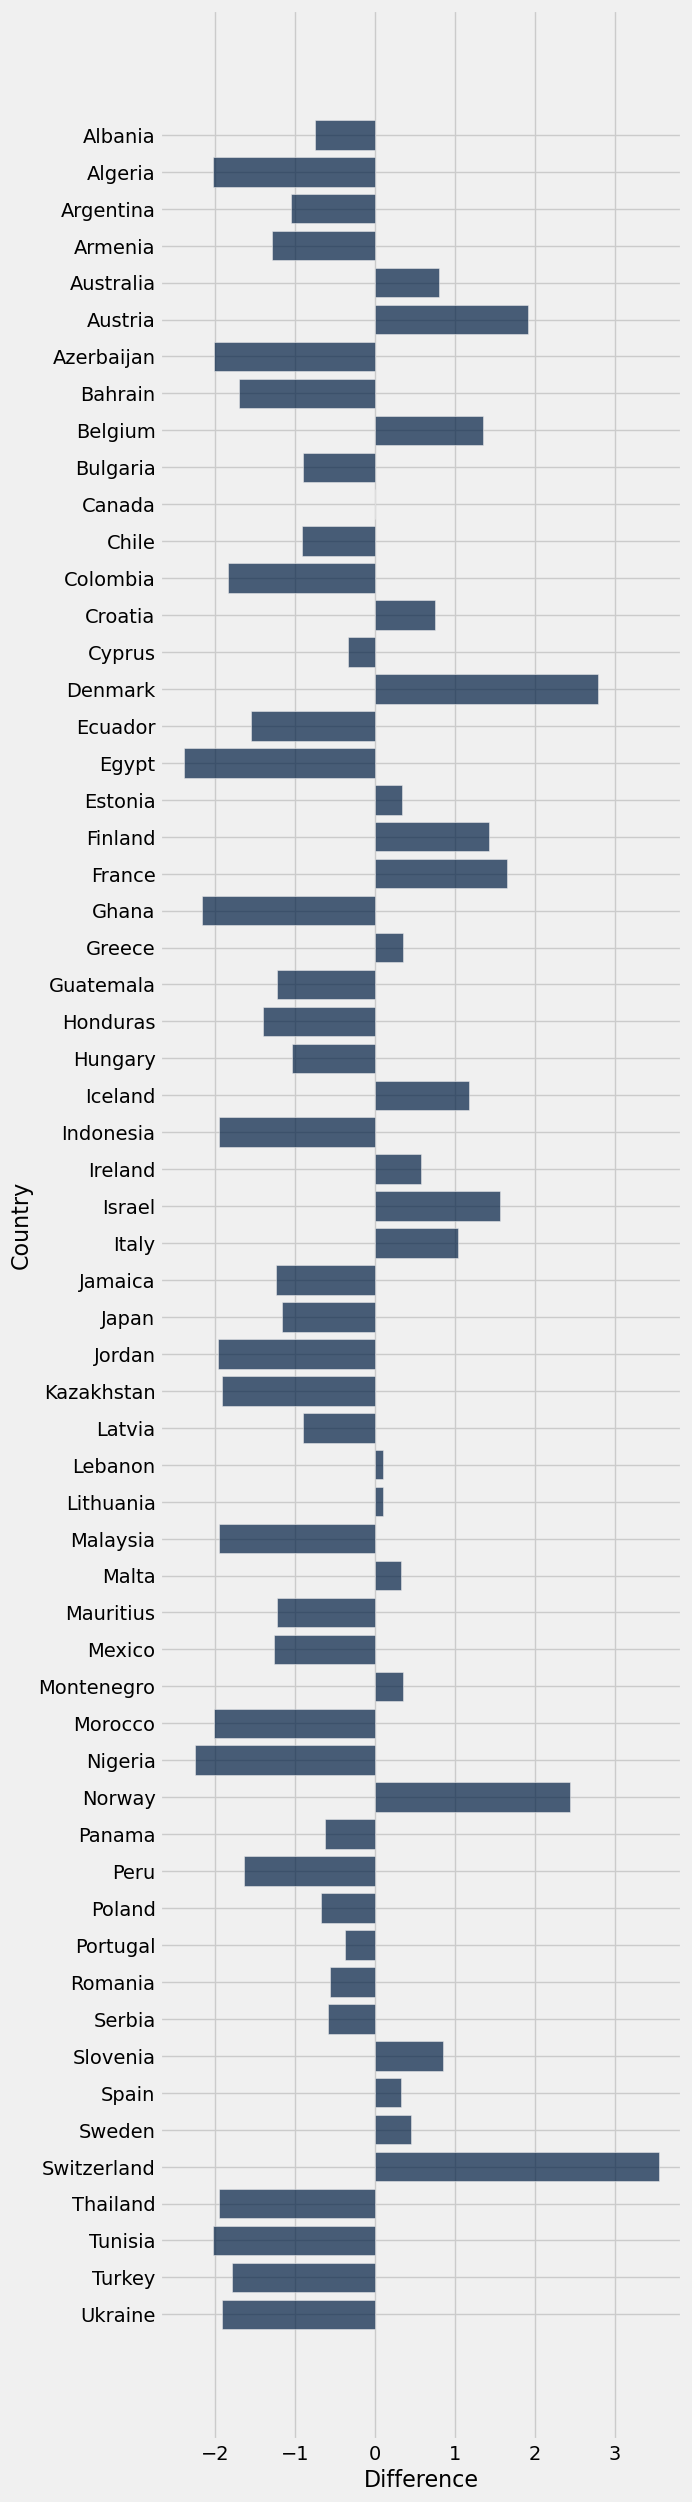

In [46]:
coke_table = coke_table.where("Country", are.not_equal_to("Singapore"))
coke_table.barh("Country", "Difference")